In [1]:
!pip install -q accelerate transformers==4.28.0 
!pip install -q datasets==2.12.0 
!pip install -q evaluate shortuuid gradio visen

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings

sns.set()
rcParams['figure.figsize'] = (20,10)
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')
from pprint import pprint

from transformers import AutoTokenizer, AutoModel, AutoConfig, pipeline
from datasets import load_dataset, DatasetDict, Dataset

In [3]:
# load squad v2
squad = load_dataset('squad_v2')
temp = squad['train'].train_test_split(test_size=0.1, shuffle=True, seed=42)
train_origin = temp['train']
val_origin = temp['test']
test_origin = squad['validation']

train_origin, val_origin, test_origin

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Dataset squad_v2 downloaded and prepared to /root/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

(Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 117287
 }),
 Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 13032
 }),
 Dataset({
     features: ['id', 'title', 'context', 'question', 'answers'],
     num_rows: 11873
 }))

In [4]:
class CustomModelForQuestionAnswering(nn.Module):
    def __init__(self, model_checkpoint):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.qa_outputs = nn.Linear(self.model.config.hidden_size, 2)
        self.W1 = nn.Linear(self.model.config.hidden_size, 1)
        self.W2 = nn.Linear(self.model.config.hidden_size, self.model.config.hidden_size)

    def forward(self, input_ids, attention_mask, start_positions=None, end_positions=None):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        cls_token = last_hidden_state[:, 0, :]

        answerable_logits = self.W1(torch.tanh(self.W2(cls_token)))
        start_logits, end_logits = self.qa_outputs(last_hidden_state).split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        
        # loss = lost_answerable + loss_start + loss_end
        loss, loss_answerable, loss_start, loss_end = None, None, None, None
        if start_positions is not None and end_positions is not None:
            answerables = ((start_positions != 0) & (end_positions != 0)).float().unsqueeze(-1)
            loss_answerable = F.binary_cross_entropy_with_logits(answerable_logits, answerables)
            loss_start = F.cross_entropy(start_logits, start_positions)
            loss_end = F.cross_entropy(end_logits, end_positions)
            loss = loss_answerable + loss_start + loss_end 

        return {
            'loss': loss,
            'answerable_logits': answerable_logits.squeeze(-1),
            'start_logits': start_logits,
            'end_logits': end_logits,
            'loss_answerable': loss_answerable,
            'loss_start': loss_start,
            'loss_end': loss_end
        }

In [5]:
model_checkpoint = 'xlm-roberta-base'
# model = CustomModelForQuestionAnswering(model_checkpoint).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [6]:
max_length = 256
stride = 128

def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
        return_tensors="pt",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        if len(answer["answer_start"]) == 0:
            start_positions.append(0)
            end_positions.append(0)
            continue

        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)
            
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids

    answers = examples["answers"]
    start_positions = []
    end_positions = []
    for i, offset in enumerate(inputs['offset_mapping']):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        if len(answer["answer_start"]) == 0:
            start_positions.append(0)
            end_positions.append(0)
            continue

        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions

    return inputs

In [8]:
# train_dataset = train_origin.map(
#     preprocess_training_examples,
#     batch_size=500,
#     batched=True,
#     remove_columns=train_origin.column_names,
# ).shuffle()
val_dataset = val_origin.map(
    preprocess_training_examples,
    batched=True,
    remove_columns=val_origin.column_names,
)
test_dataset = test_origin.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=test_origin.column_names,
)

Map:   0%|          | 0/13032 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [19]:
val_dataset_test = val_origin.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=val_origin.column_names,
)

Map:   0%|          | 0/13032 [00:00<?, ? examples/s]

In [11]:
def train(model, train_dataset, val_dataset, epochs=2, batch_size=24, lr=3e-5, train_eval_steps=1000, test_eval_steps=1000, accumulate_grad_steps=3, save_steps=2500):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    train_dataset.set_format(type='torch')
    val_dataset.set_format(type='torch')

    step = 0
    for epoch in tqdm(range(epochs)):
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        model.train()
        train_loss, train_loss_answerable, train_loss_start, train_loss_end = [], [], [], []
        for batch in tqdm(train_dataloader):
            step += 1

            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)

            loss = outputs['loss']
            loss.backward()

            train_loss.append(loss.item())
            train_loss_answerable.append(outputs['loss_answerable'].item())
            train_loss_start.append(outputs['loss_start'].item())
            train_loss_end.append(outputs['loss_end'].item())
            
            if step % accumulate_grad_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            if step % train_eval_steps == 0:
                print(f"Epoch {epoch+1}/{epochs} | Step {step} | Train loss: {np.mean(train_loss):.3f} | Train loss answerable: {np.mean(train_loss_answerable):.3f} | Train loss start: {np.mean(train_loss_start):.3f} | Train loss end: {np.mean(train_loss_end):.3f}")
                train_loss, train_loss_answerable, train_loss_start, train_loss_end = [], [], [], []

            if step % test_eval_steps == 0:
                model.eval()
                val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
                val_loss, val_loss_answerable, val_loss_start, val_loss_end = [], [], [], []

                with torch.no_grad():
                    for batch in tqdm(val_dataloader):
                        inputs = {k: v.to(device) for k, v in batch.items()}
                        outputs = model(**inputs)
                        loss = outputs['loss']

                        val_loss.append(loss.item())
                        val_loss_answerable.append(outputs['loss_answerable'].item())
                        val_loss_start.append(outputs['loss_start'].item())
                        val_loss_end.append(outputs['loss_end'].item())
                        
                print(f"Epoch {epoch+1}/{epochs} | Step {step} | Val loss: {np.mean(val_loss):.3f} | Val loss answerable: {np.mean(val_loss_answerable):.3f} | Val loss start: {np.mean(val_loss_start):.3f} | Val loss end: {np.mean(val_loss_end):.3f}")
                model.train()

            if step % save_steps == 0:
                torch.save(model, './model_step_{}.pth'.format(step))

    train_dataset.reset_format()
    val_dataset.reset_format()

In [ ]:
train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=2,
    batch_size=24,
    lr=3e-5,
    train_eval_steps=500,
    test_eval_steps=1000,
    accumulate_grad_steps=3
)

In [ ]:
torch.save(model, './final_model.pth')

### Inference

In [13]:
from collections import defaultdict
import evaluate
from tqdm.auto import tqdm
metric = evaluate.load("squad_v2")
from tqdm.auto import tqdm
def compute_metrics(
    start_logits,
    end_logits,
    answerable_logits,
    features,
    examples,
    metric=metric,
    n_best=5,
    max_answer_length=100,
    show_result=True,
    threshold=0.7,
):
    example_to_features = defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            answerable_logit = answerable_logits[feature_index]
            prob = torch.sigmoid(torch.tensor(answerable_logit))
            if prob < threshold:
                continue

            candidate_answers = []
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]
            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip candidate_answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip candidate_answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue
                    answer = {
                        "text": context[
                            offsets[start_index][0] : offsets[end_index][1]
                        ],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                        'no_answer_probability': 1 - prob.item(),

                    }
                    candidate_answers.append(answer)

            # Add the best candidate_answers with a score > zero to the final list
            candidate_answers = sorted(
                candidate_answers, key=lambda x: x["logit_score"], reverse=True
            )
            if len(candidate_answers) > 0:
                answers.append(candidate_answers[0])
        
        if len(answers) == 0:
            predicted_answers.append({"id": example_id, "prediction_text": "", "no_answer_probability":1.0})
        else:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"], "no_answer_probability": 0.0}
            )

    theoretical_answers = [
        {
            "id": ex["id"],
            "answers": {
                "text": ex["answers"]["text"],
                "answer_start": ex["answers"]["answer_start"],
            },
        }
        for ex in examples
    ]
    if show_result:
        i = 0
        for pred, theo in zip(predicted_answers, theoretical_answers):
            i += 1
            if i == 100:
                break
            print(pred['prediction_text'])
            print(theo['answers']['text'])
            print('----' * 30)
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

def compute_answerable_metrics(answerable_logits, examples):
    from sklearn.metrics import classification_report
    predicted_answers = answerable_logits > 0
    predicted_answers = predicted_answers.astype(int).tolist()
    actual_answers = (np.array(examples['start_positions']) != 0) & (np.array(examples['end_positions']) != 0)
    actual_answers = actual_answers.astype(int).tolist()
    print(classification_report(actual_answers, predicted_answers))

def get_predictions(model, dataset, batch_size=64):
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_start_logits = []
    all_end_logits = []
    all_answerable_logits = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs, start_positions=None, end_positions=None)
            all_start_logits.append(outputs['start_logits'].cpu())
            all_end_logits.append(outputs['end_logits'].cpu())
            all_answerable_logits.append(outputs['answerable_logits'].cpu())
    all_start_logits = torch.cat(all_start_logits, dim=0)
    all_end_logits = torch.cat(all_end_logits, dim=0)
    all_answerable_logits = torch.cat(all_answerable_logits, dim=0)
    dataset.reset_format()
    return {
        'start_logits': all_start_logits.cpu().numpy(),
        'end_logits': all_end_logits.cpu().numpy(),
        'answerable_logits': all_answerable_logits.cpu().numpy(),
    }

def show_threshold_vs_score(thresholds, exacts, f1s):
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, exacts, label='exact')
    plt.plot(thresholds, f1s, label='f1')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

In [14]:
model = torch.load('/kaggle/input/bert-base-case-squad2-models/model_step_10000.pth')

In [20]:
predictions = get_predictions(model, val_dataset_test, batch_size=64)
val_start_logits, val_end_logits, val_answerable_logits = predictions['start_logits'], predictions['end_logits'], predictions['answerable_logits']

  0%|          | 0/245 [00:00<?, ?it/s]

In [21]:
thresholds = 0.05 * np.arange(4,20,1)
metrics = []
for threshold in tqdm(thresholds):
    metrics.append(compute_metrics(val_start_logits, val_end_logits, val_answerable_logits, val_dataset_test, val_origin, threshold=threshold, show_result=False))

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

  0%|          | 0/13032 [00:00<?, ?it/s]

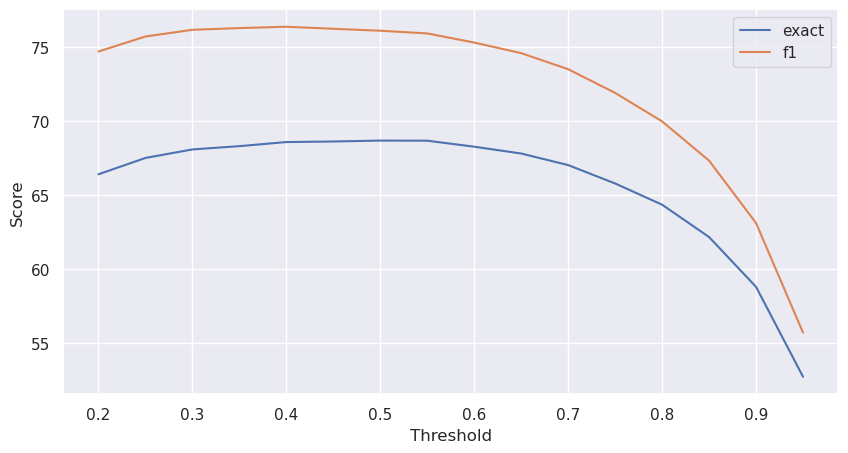

In [22]:
exacts = [m['exact'] for m in metrics]
f1s = [m['f1'] for m in metrics]
show_threshold_vs_score(thresholds, exacts, f1s)

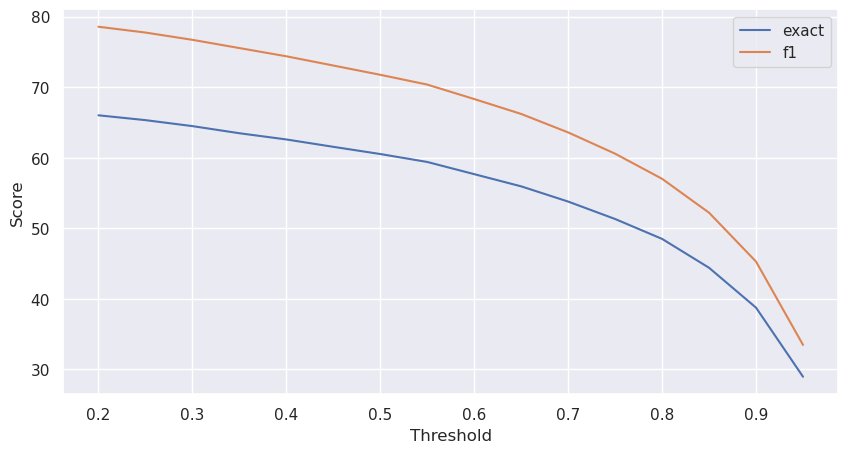

In [23]:
has_ans_exacts = [m['HasAns_exact'] for m in metrics]
has_ans_f1s = [m['HasAns_f1'] for m in metrics]
show_threshold_vs_score(thresholds, has_ans_exacts, has_ans_f1s)

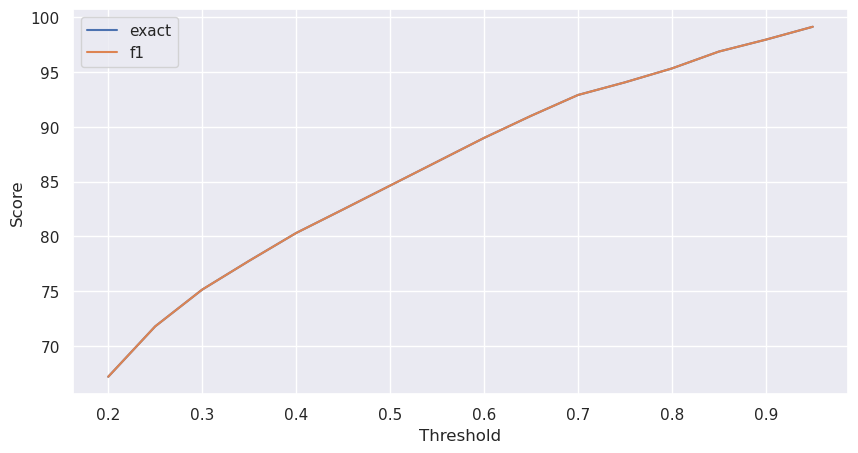

In [24]:
no_ans_exacts = [m['NoAns_exact'] for m in metrics]
no_ans_f1s = [m['NoAns_f1'] for m in metrics]
show_threshold_vs_score(thresholds, no_ans_exacts, no_ans_f1s)

In [25]:
predictions = get_predictions(model, test_dataset, batch_size=64)
start_logits, end_logits, answerable_logits = predictions['start_logits'], predictions['end_logits'], predictions['answerable_logits']

  0%|          | 0/233 [00:00<?, ?it/s]

In [26]:
compute_metrics(start_logits, end_logits, answerable_logits, test_dataset, test_origin, threshold=0.45, show_result=False)

  0%|          | 0/11873 [00:00<?, ?it/s]

{'exact': 73.83980459866925,
 'f1': 76.24973505251289,
 'total': 11873,
 'HasAns_exact': 60.50944669365722,
 'HasAns_f1': 65.33621867045983,
 'HasAns_total': 5928,
 'NoAns_exact': 87.13204373423045,
 'NoAns_f1': 87.13204373423045,
 'NoAns_total': 5945,
 'best_exact': 73.83980459866925,
 'best_exact_thresh': 0.0,
 'best_f1': 76.24973505251292,
 'best_f1_thresh': 0.0}